In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

In [2]:
def get_bits(x, n):
    return [int(x) for x in '{:0{size}b}'.format(x, size=n)]

def generate_carry(constant, n):
    name = 'Carry ({0})'.format(constant)
    constant_bits = get_bits(constant, n)
    
    qrCtrl = QuantumRegister(1, name='ctrl')
    qrA = QuantumRegister(n, name='a')
    qrC = QuantumRegister(1, name='c')
    
    # special case for n = 1: 
    if n == 1:
        qc = QuantumCircuit(qrCtrl, qrA, qrC, name=name)
    
        if constant_bits[0] == 1:
            qc.ccx(qrCtrl[0], qrA[0], qrC)
        
        return qc.to_instruction()
    
    # for n >= 2:
    qrG = QuantumRegister(n-1, name='g')
    
    qc = QuantumCircuit(qrCtrl, qrA, qrG, qrC, name=name)

    qc.ccx(qrCtrl[0], qrG[n - 2], qrC)

    for i in range(n - 1, 1, -1):
        if constant_bits[n - (i + 1)] == 1:
            qc.cx(qrA[i], qrG[i - 1])
            qc.x(qrA[i])
        qc.ccx(qrG[i - 2], qrA[i], qrG[i - 1])

    if constant_bits[n - 2] == 1:
        qc.cx(qrA[1], qrG[0])
        qc.x(qrA[1])
        
    if constant_bits[n - 1] == 1:
        qc.ccx(qrA[0], qrA[1], qrG[0])

    for i in range(2, n):
        qc.ccx(qrG[i - 2], qrA[i], qrG[i - 1])

    qc.ccx(qrCtrl[0], qrG[n - 2], qrC)
   
    for i in range(n - 1, 1, -1):
        qc.ccx(qrG[i - 2], qrA[i], qrG[i - 1])

    if constant_bits[n - 1] == 1:
        qc.ccx(qrA[0], qrA[1], qrG[0])
        
    if constant_bits[n - 2] == 1:
        qc.x(qrA[1])
        qc.cx(qrA[1], qrG[0])

    for i in range(2, n):
        qc.ccx(qrG[i - 2], qrA[i], qrG[i - 1])
        if constant_bits[n - (i + 1)] == 1:
            qc.x(qrA[i])
            qc.cx(qrA[i], qrG[i - 1])
    
    return qc.to_instruction()

def generate_substractor(n):
    qrCtrl = QuantumRegister(1, name='ctrl')
    qrX = QuantumRegister(n, name='g')
    qrY = QuantumRegister(n, name='a')
        
    qc = QuantumCircuit(qrCtrl, qrY, qrX)
    
    # 3.6
    for i in range(n-1, 0, -1):
        qc.cx(qrX[i], qrY[i])
        
    qc.ccx(qrCtrl[0], qrX[0], qrY[0])
    
    # 3.5
    for i in range(n-1, 1, -1):
        qc.cx(qrX[i-1], qrX[i])

    # 3.4
    for i in range(1, n):
        qc.ccx(qrX[i-1], qrY[i-1], qrX[i])
        
        qc.ccx(qrCtrl[0], qrX[i], qrY[i])

    # 3.3
    for i in range(n-1, 0, -1):
        qc.ccx(qrX[i-1], qrY[i-1], qrX[i])

    # 3.2
    for i in range(1, n-1):
        qc.cx(qrX[i], qrX[i+1])

    # 3.1
    for i in range(n-1, 0, -1):
        qc.cx(qrX[i], qrY[i])
        
    return qc

def generate_negation_part(n):
    qrG = QuantumRegister(n, name='g')
    
    qc = QuantumCircuit(qrG)
    
    qc.barrier(qrG[:])
    for i in range(n):
        qc.x(qrG[i])
    qc.barrier(qrG[:])
    
    return qc

def generate_incrementator(n):
    qc_sub = generate_substractor(n)
    qc_neg = generate_negation_part(n)
    
    qc = qc_sub + qc_neg + qc_sub + qc_neg
    qc.name = 'Inc'
    return qc.to_instruction()

def generate_controlled_negation(n):
    qrCtrl = QuantumRegister(1, name='ctrl')
    qrG = QuantumRegister(n, name='g')
    
    qc = QuantumCircuit(qrCtrl, qrG)
    
    qc.barrier(qrG[:])
    for i in range(n):
        qc.cx(qrCtrl[0], qrG[i])
    qc.barrier(qrG[:])
    
    return qc.to_instruction()

def generate_constant_adder(constant, n):
    name = 'Add ({0})'.format(constant)
    
    qrCtrl = QuantumRegister(1, 'ctrl')
    qrX = QuantumRegister(n, 'x')
    qrC = QuantumRegister(1, 'carry')
    
    qc = QuantumCircuit(qrCtrl, qrX, qrC, name=name)
    
    if n == 1:
        if constant == 1:
            qc.cx(qrCtrl[0], qrX[0])
        return qc.to_instruction()
    
    i = n // 2 + n % 2
    
    low = constant & ((1 << i) - 1)
    high = constant >> i
    
    qrX_L = qrX[:i]
    qrX_H = qrX[i:]
    
    carry = generate_carry(low, i)
    inc = generate_incrementator(n - i)
    neg = generate_controlled_negation(n - i)
    
    qc.append(inc, qrC[:] + qrX_H[:] + qrX_L[:len(qrX_H)])
    qc.append(neg, qrC[:] + qrX_H[:])
    
    qc.append(carry, qrCtrl[:] + qrX_L[:] + qrX_H[:(i-1)] + qrC[:])
    qc.append(inc, qrC[:] + qrX_H[:] + qrX_L[:len(qrX_H)])
    qc.append(carry, qrCtrl[:] + qrX_L[:] + qrX_H[:(i-1)] + qrC[:])
    
    qc.append(neg, qrC[:] + qrX_H[:])
    
    qc.append(generate_constant_adder(low, i), qrCtrl[:] + qrX[:i] + qrC[:])
    qc.append(generate_constant_adder(high, n - i), qrCtrl[:] + qrX[i:] + qrC[:])
    
    return qc.to_instruction()

def generate_constant_substractor(constant, n):
    adder = generate_constant_adder(constant, n)
    return adder.inverse()

In [3]:
def generate_constant_modulo_adder(constant, N, n):
    name = 'Add({0}) Mod {1}'.format(constant, N)
    
    qrCtrl = QuantumRegister(1, 'ctrl')
    qrX = QuantumRegister(n, 'x')
    qrC = QuantumRegister(1, 'carry')
    qrG = QuantumRegister(1, 'dirty')
    qrFlag = QuantumRegister(1, 'flag')

    addC = generate_constant_adder(constant, n+1)
    subN = generate_constant_substractor(N, n+1)
    addN = generate_constant_adder(N, n+1)
    subC = generate_constant_substractor(constant, n+1)
        
    qc = QuantumCircuit(qrCtrl, qrX, qrC, qrG, qrFlag, name=name)
    
    qc.append(addC, qrCtrl[:] + qrX[:] + qrC[:] + qrG[:])
    qc.append(subN, qrCtrl[:] + qrX[:] + qrC[:] + qrG[:])
    qc.ccx(qrCtrl[0], qrC[0], qrFlag[0])
    qc.append(addN, qrFlag[:] + qrX[:] + qrC[:] + qrG[:])
    
    qc.x(qrC[0])
    qc.append(subC, qrCtrl[:] + qrX[:] + qrC[:] + qrG[:])
    qc.ccx(qrCtrl[0], qrC[0], qrFlag[0])
    qc.append(addC, qrCtrl[:] + qrX[:] + qrC[:] + qrG[:])
    qc.x(qrC[0])
    
    return qc.to_instruction()

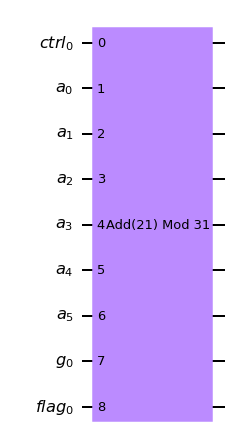

In [4]:
_qrCtrl = QuantumRegister(1, name='ctrl')
_qrA = QuantumRegister(6, name='a')
_qrG = QuantumRegister(1, name='g')
_qrF = QuantumRegister(1, name='flag')
_qc = QuantumCircuit(_qrCtrl, _qrA, _qrG, _qrF)

caddmod = generate_constant_modulo_adder(21, 31, 5)
_qc.append(caddmod, _qrCtrl[:] + _qrA[:] + _qrG[:] + _qrF[:])
_qc.draw(output='mpl')

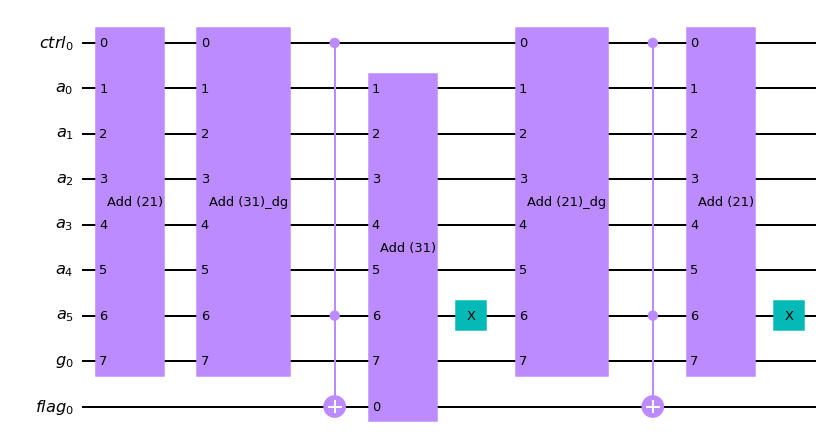

In [5]:
_dec = _qc.decompose()
_dec.draw(output='mpl')

In [77]:
def generate_init_part(ctrl, x, g, n):
    qrCtrl = QuantumRegister(1, name='ctrl')
    qrX = QuantumRegister(n, name='x')
    qrG = QuantumRegister(1, name='g')
    qc = QuantumCircuit(qrCtrl, qrX, qrG)
      
    if ctrl:
        qc.x(qrCtrl[0])
        
    x_bits = get_bits(x, n)
    for i in range(n):
        if x_bits[n-(i+1)] == 1:
            qc.x(qrX[i])
                
    if g == 1:
        qc.x(qrG[0])

    qc.barrier(qrCtrl[:], qrX[:], qrG[:])
        
    return qc

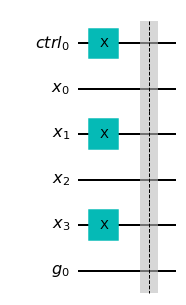

In [78]:
_qcInit = generate_init_part(True, 10, 5, 4)
_qcInit.draw(output='mpl')

In [79]:
def generate_measure_part(n):
    qrX = QuantumRegister(n, name='x')
    qrC = QuantumRegister(1, name='carry')
    qrG = QuantumRegister(1, name='g')
    qrF = QuantumRegister(1, name='flag')
    
    crX = ClassicalRegister(n, name='xValue')
    crC = ClassicalRegister(1, name='cValue')
    crG = ClassicalRegister(1, name='gValue')
    crF = ClassicalRegister(1, name='fValue')
    
    qc = QuantumCircuit(qrX, qrC, qrG, qrF, crX, crC, crG, crF)
    qc.barrier(qrX[:], qrG[:], qrC[:], qrF[:])
        
    qc.measure(qrX[:], crX[:])
    qc.measure(qrC[:], crC[:])
    qc.measure(qrG[:], crG[:])
    qc.measure(qrF[:], crF[:])
    
    return qc

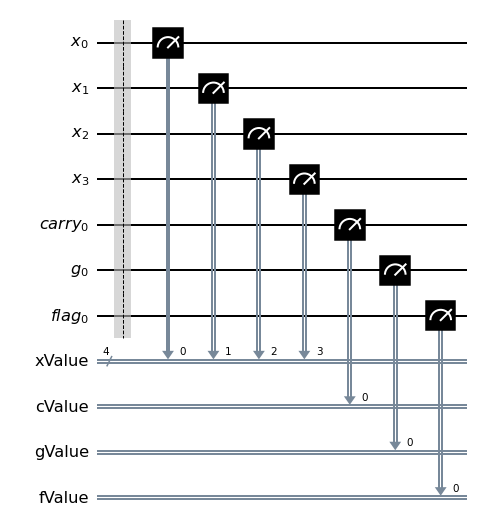

In [80]:
_qcMeas = generate_measure_part(4)
_qcMeas.draw(output='mpl')

In [81]:
def test_constant_modulo_addition(ctrl, x, constant, N, value):
    expected_value = (x + constant) % N if ctrl else x
    print(expected_value, value, expected_value == value)

In [82]:
from qiskit import Aer
from qiskit import execute

backend = Aer.get_backend('qasm_simulator')

In [119]:
def test(ctrl, x, constant, N, g, n):
    qrCtrl = QuantumRegister(1, name='ctrl')
    qrX = QuantumRegister(n, name='x')
    qrC = QuantumRegister(1, name='carry')
    qrG = QuantumRegister(1, name='g')
    qrF = QuantumRegister(1, name='flag')
    
    qc = QuantumCircuit(qrCtrl, qrX, qrG, qrC, qrF)
        
    qc += generate_init_part(ctrl, x, g, n)
    
    qc.append(generate_constant_modulo_adder(constant, N, n), qrCtrl[:] + qrX[:] + qrC[:] + qrG[:] + qrF[:])
        
    qc += generate_measure_part(n)

    job = execute(qc, backend, shots=1)
    result = job.result()
    values = list(result.get_counts(qc).keys())

    assert len(values) == 1
    values = [int(v, 2) for v in values[0].split(' ')]

    f_value = values[0]
    g_value = values[1]
    c_value = values[2]
    x_value = values[3]

    print(0, f_value, 0 == f_value)
    print(g, g_value, g == g_value)
    print(0, c_value, 0 == c_value)
    test_constant_modulo_addition(ctrl, x, constant, N, x_value)
        
#     return qc

In [116]:
_qc = test(True, 6, 21, 31, 1, 5)

0 0 True
1 1 True
0 0 True
27 27 True


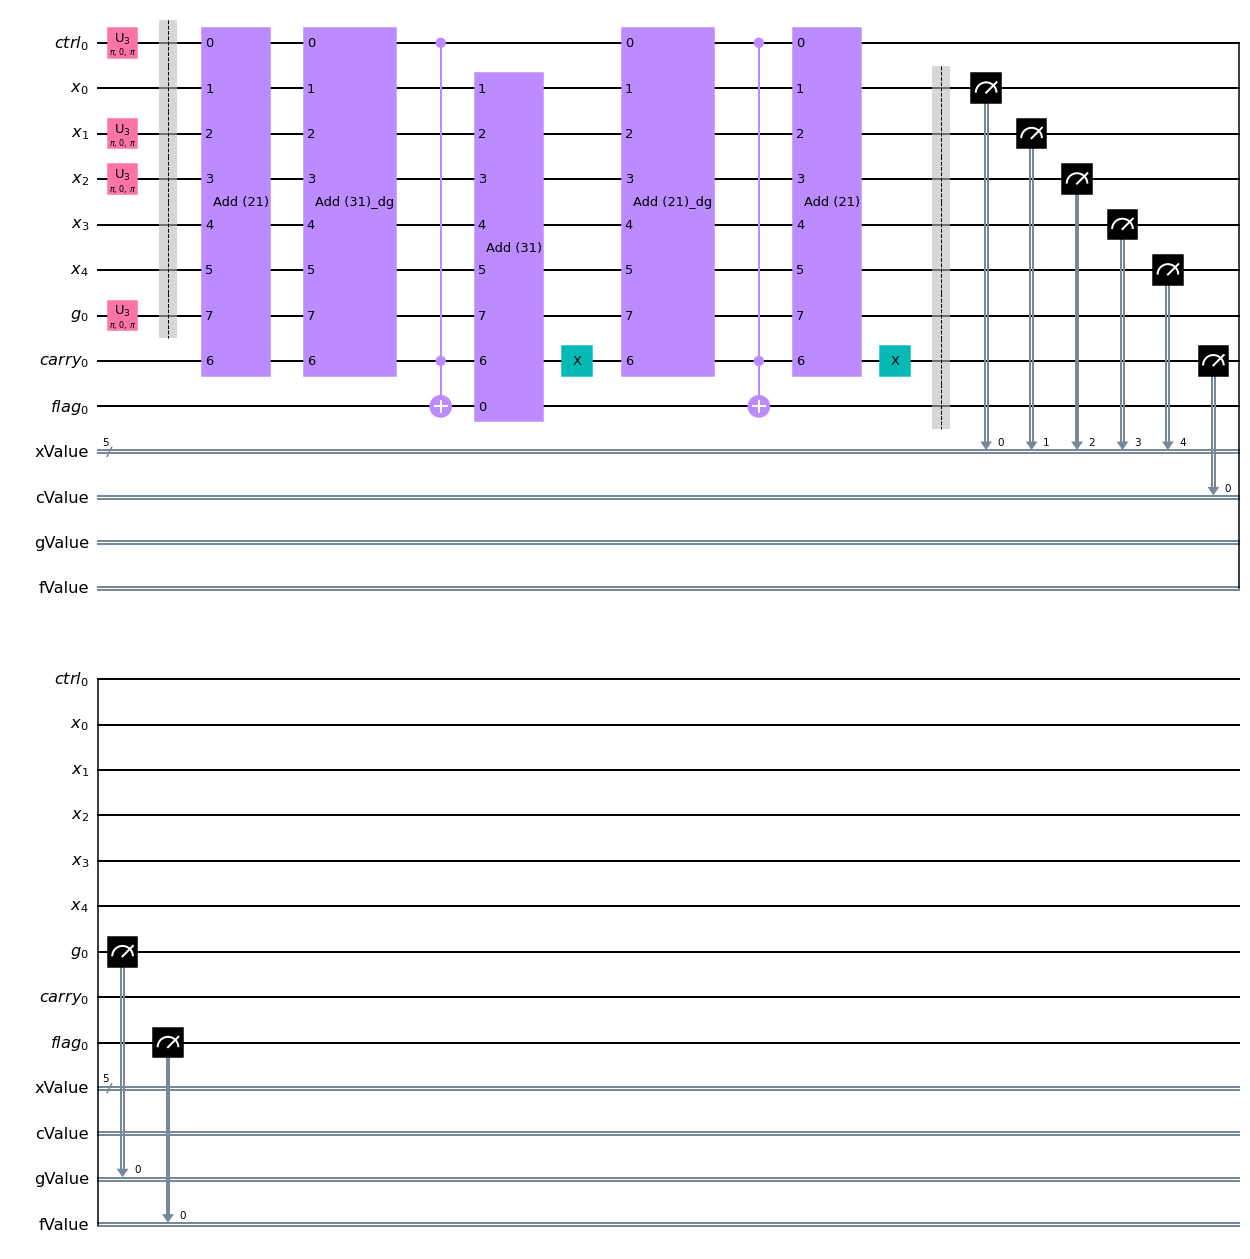

In [117]:
_dec = _qc.decompose()
_dec.draw(output='mpl')

In [118]:
test(False, 14, 21, 31, 1, 5)

0 0 True
1 1 True
0 0 True
14 14 True


In [120]:
for n in range(4):
    n = n + 1
    print(n)
    
    for N in range(1, 2 ** n):
        for x in range(N):
            for c in range(N):
                for g in range(2):
                    print('---', 1, '-', x, c, N, g, '---')
                    test(True, x, c, N, g, n)

1
--- 1 - 0 0 1 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 1 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
2
--- 1 - 0 0 1 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 1 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 0 2 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 2 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 1 2 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 0 1 2 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 1 0 2 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 1 0 2 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 1 1 2 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 1 1 2 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 0 3 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 3 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 1 3 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 0 1 3 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 0 2 3 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 0 2 3 1 ---
0 0 True
1 1 True
0 0 Tr

0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 0 3 6 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 0 4 6 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 0 4 6 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 0 5 6 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 0 5 6 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 1 0 6 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 1 0 6 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 1 1 6 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 1 1 6 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 1 2 6 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 1 2 6 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 1 3 6 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 1 3 6 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 1 4 6 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 1 4 6 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 1 5 6 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 1 5 6 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 2 0 

0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 5 6 7 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 5 6 7 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 6 0 7 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 6 0 7 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 6 1 7 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 6 1 7 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 6 2 7 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 6 2 7 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 6 3 7 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 6 3 7 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 6 4 7 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 6 4 7 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 6 5 7 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 6 5 7 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 6 6 7 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 6 6 7 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
4
--- 1 - 0 0 1 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 

0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 1 4 6 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 1 5 6 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 1 5 6 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 2 0 6 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 2 0 6 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 2 1 6 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 2 1 6 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 2 2 6 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 2 2 6 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 2 3 6 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 2 3 6 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 2 4 6 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 2 4 6 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 2 5 6 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 2 5 6 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 3 0 6 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 3 0 6 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 3 1 

0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 6 6 7 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 6 6 7 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 0 0 8 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 8 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 1 8 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 0 1 8 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 0 2 8 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 0 2 8 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 0 3 8 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 0 3 8 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 0 4 8 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 0 4 8 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 0 5 8 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 0 5 8 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 0 6 8 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 0 6 8 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 0 7 8 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 0 7 

0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 0 8 9 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 1 0 9 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 1 0 9 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 1 1 9 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 1 1 9 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 1 2 9 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 1 2 9 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 1 3 9 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 1 3 9 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 1 4 9 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 1 4 9 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 1 5 9 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 1 5 9 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 1 6 9 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 1 6 9 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 1 7 9 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 1 7 9 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 1 8 

0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 1 10 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 0 1 10 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 0 2 10 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 0 2 10 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 0 3 10 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 0 3 10 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 0 4 10 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 0 4 10 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 0 5 10 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 0 5 10 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 0 6 10 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 0 6 10 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 0 7 10 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 0 7 10 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 0 8 10 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 0 8 10 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 0 9 10 0 ---
0 0 True
0 0 True
0 0 True
9 9 

0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 7 3 10 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 7 3 10 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 7 4 10 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 7 4 10 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 7 5 10 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 7 5 10 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 7 6 10 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 7 6 10 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 7 7 10 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 7 7 10 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 7 8 10 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 7 8 10 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 7 9 10 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 7 9 10 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 8 0 10 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 8 0 10 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 8 1 10 0 ---
0 0 True
0 0 True
0 0 True
9 9 

0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 4 1 11 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 4 1 11 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 4 2 11 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 4 2 11 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 4 3 11 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 4 3 11 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 4 4 11 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 4 4 11 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 4 5 11 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 4 5 11 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 4 6 11 0 ---
0 0 True
0 0 True
0 0 True
10 10 True
--- 1 - 4 6 11 1 ---
0 0 True
1 1 True
0 0 True
10 10 True
--- 1 - 4 7 11 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 4 7 11 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 4 8 11 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 4 8 11 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 4 9 11 0 ---
0 0 True
0 0 True
0 0 True


0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 10 6 11 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 10 7 11 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 10 7 11 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 10 8 11 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 10 8 11 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 10 9 11 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 10 9 11 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 10 10 11 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 10 10 11 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 0 0 12 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 12 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 1 12 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 0 1 12 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 0 2 12 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 0 2 12 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 0 3 12 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 0 3 12 1 ---
0 0 True
1 1 True
0 

0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 5 7 12 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 5 7 12 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 5 8 12 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 5 8 12 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 5 9 12 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 5 9 12 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 5 10 12 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 5 10 12 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 5 11 12 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 5 11 12 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 6 0 12 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 6 0 12 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 6 1 12 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 6 1 12 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 6 2 12 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 6 2 12 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 6 3 12 0 ---
0 0 True
0 0 True
0 0 Tru

0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 11 6 12 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 11 6 12 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 11 7 12 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 11 7 12 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 11 8 12 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 11 8 12 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 11 9 12 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 11 9 12 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 11 10 12 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 11 10 12 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 11 11 12 0 ---
0 0 True
0 0 True
0 0 True
10 10 True
--- 1 - 11 11 12 1 ---
0 0 True
1 1 True
0 0 True
10 10 True
--- 1 - 0 0 13 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 0 0 13 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 0 1 13 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 0 1 13 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 0 2 13 0 ---
0 0 True
0 

0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 5 0 13 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 5 0 13 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 5 1 13 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 5 1 13 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 5 2 13 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 5 2 13 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 5 3 13 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 5 3 13 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 5 4 13 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 5 4 13 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 5 5 13 0 ---
0 0 True
0 0 True
0 0 True
10 10 True
--- 1 - 5 5 13 1 ---
0 0 True
1 1 True
0 0 True
10 10 True
--- 1 - 5 6 13 0 ---
0 0 True
0 0 True
0 0 True
11 11 True
--- 1 - 5 6 13 1 ---
0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 5 7 13 0 ---
0 0 True
0 0 True
0 0 True
12 12 True
--- 1 - 5 7 13 1 ---
0 0 True
1 1 True
0 0 True
12 12 True
--- 1 - 5 8 13 0 ---
0 0 True
0 0 True
0

0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 10 6 13 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 10 6 13 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 10 7 13 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 10 7 13 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 10 8 13 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 10 8 13 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 10 9 13 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 10 9 13 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 10 10 13 0 ---
0 0 True
0 0 True
0 0 True
7 7 True
--- 1 - 10 10 13 1 ---
0 0 True
1 1 True
0 0 True
7 7 True
--- 1 - 10 11 13 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 10 11 13 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 10 12 13 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 10 12 13 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 11 0 13 0 ---
0 0 True
0 0 True
0 0 True
11 11 True
--- 1 - 11 0 13 1 ---
0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 11 1 13 0 ---
0 0 

0 0 True
0 0 True
0 0 True
11 11 True
--- 1 - 2 9 14 1 ---
0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 2 10 14 0 ---
0 0 True
0 0 True
0 0 True
12 12 True
--- 1 - 2 10 14 1 ---
0 0 True
1 1 True
0 0 True
12 12 True
--- 1 - 2 11 14 0 ---
0 0 True
0 0 True
0 0 True
13 13 True
--- 1 - 2 11 14 1 ---
0 0 True
1 1 True
0 0 True
13 13 True
--- 1 - 2 12 14 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 2 12 14 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 2 13 14 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 2 13 14 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 3 0 14 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 3 0 14 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 3 1 14 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 3 1 14 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 3 2 14 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 3 2 14 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 3 3 14 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 3 3 14 1 ---
0 0 True
1 

0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 7 10 14 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 7 11 14 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 7 11 14 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 7 12 14 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 7 12 14 1 ---
0 0 True
1 1 True
0 0 True
5 5 True
--- 1 - 7 13 14 0 ---
0 0 True
0 0 True
0 0 True
6 6 True
--- 1 - 7 13 14 1 ---
0 0 True
1 1 True
0 0 True
6 6 True
--- 1 - 8 0 14 0 ---
0 0 True
0 0 True
0 0 True
8 8 True
--- 1 - 8 0 14 1 ---
0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 8 1 14 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 8 1 14 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 8 2 14 0 ---
0 0 True
0 0 True
0 0 True
10 10 True
--- 1 - 8 2 14 1 ---
0 0 True
1 1 True
0 0 True
10 10 True
--- 1 - 8 3 14 0 ---
0 0 True
0 0 True
0 0 True
11 11 True
--- 1 - 8 3 14 1 ---
0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 8 4 14 0 ---
0 0 True
0 0 True
0 0 True
12 12 True
--- 1 - 8 4 14 1 ---
0 0 True
1 1 T

0 0 True
1 1 True
0 0 True
8 8 True
--- 1 - 12 11 14 0 ---
0 0 True
0 0 True
0 0 True
9 9 True
--- 1 - 12 11 14 1 ---
0 0 True
1 1 True
0 0 True
9 9 True
--- 1 - 12 12 14 0 ---
0 0 True
0 0 True
0 0 True
10 10 True
--- 1 - 12 12 14 1 ---
0 0 True
1 1 True
0 0 True
10 10 True
--- 1 - 12 13 14 0 ---
0 0 True
0 0 True
0 0 True
11 11 True
--- 1 - 12 13 14 1 ---
0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 13 0 14 0 ---
0 0 True
0 0 True
0 0 True
13 13 True
--- 1 - 13 0 14 1 ---
0 0 True
1 1 True
0 0 True
13 13 True
--- 1 - 13 1 14 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 13 1 14 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 13 2 14 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 13 2 14 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 13 3 14 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 13 3 14 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 13 4 14 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 13 4 14 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 13 5 14 0 

0 0 True
0 0 True
0 0 True
11 11 True
--- 1 - 3 8 15 1 ---
0 0 True
1 1 True
0 0 True
11 11 True
--- 1 - 3 9 15 0 ---
0 0 True
0 0 True
0 0 True
12 12 True
--- 1 - 3 9 15 1 ---
0 0 True
1 1 True
0 0 True
12 12 True
--- 1 - 3 10 15 0 ---
0 0 True
0 0 True
0 0 True
13 13 True
--- 1 - 3 10 15 1 ---
0 0 True
1 1 True
0 0 True
13 13 True
--- 1 - 3 11 15 0 ---
0 0 True
0 0 True
0 0 True
14 14 True
--- 1 - 3 11 15 1 ---
0 0 True
1 1 True
0 0 True
14 14 True
--- 1 - 3 12 15 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 3 12 15 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 3 13 15 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 3 13 15 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 3 14 15 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 3 14 15 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 4 0 15 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 4 0 15 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 4 1 15 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 4 1 15 1 ---
0 0 T

0 0 True
0 0 True
0 0 True
12 12 True
--- 1 - 8 4 15 1 ---
0 0 True
1 1 True
0 0 True
12 12 True
--- 1 - 8 5 15 0 ---
0 0 True
0 0 True
0 0 True
13 13 True
--- 1 - 8 5 15 1 ---
0 0 True
1 1 True
0 0 True
13 13 True
--- 1 - 8 6 15 0 ---
0 0 True
0 0 True
0 0 True
14 14 True
--- 1 - 8 6 15 1 ---
0 0 True
1 1 True
0 0 True
14 14 True
--- 1 - 8 7 15 0 ---
0 0 True
0 0 True
0 0 True
0 0 True
--- 1 - 8 7 15 1 ---
0 0 True
1 1 True
0 0 True
0 0 True
--- 1 - 8 8 15 0 ---
0 0 True
0 0 True
0 0 True
1 1 True
--- 1 - 8 8 15 1 ---
0 0 True
1 1 True
0 0 True
1 1 True
--- 1 - 8 9 15 0 ---
0 0 True
0 0 True
0 0 True
2 2 True
--- 1 - 8 9 15 1 ---
0 0 True
1 1 True
0 0 True
2 2 True
--- 1 - 8 10 15 0 ---
0 0 True
0 0 True
0 0 True
3 3 True
--- 1 - 8 10 15 1 ---
0 0 True
1 1 True
0 0 True
3 3 True
--- 1 - 8 11 15 0 ---
0 0 True
0 0 True
0 0 True
4 4 True
--- 1 - 8 11 15 1 ---
0 0 True
1 1 True
0 0 True
4 4 True
--- 1 - 8 12 15 0 ---
0 0 True
0 0 True
0 0 True
5 5 True
--- 1 - 8 12 15 1 ---
0 0 True
1 1 

KeyboardInterrupt: 